In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.integrate import quad
import vegas
plt.style.use("figures.mplstyle")

from src.constants import *
from src.xs_and_decays import *
from src.balloon import *

# muon beam
E_mu = 1500 # GeV
E_N = E_mu/2 # roughly speaking

In [24]:
def r_c_at_detector(theta_mu, phi, l_mu, z0):

    # origin of cherenkov light
    r0 = np.array([0,
                   l_mu * np.sin(theta_mu),
                   l_mu * np.cos(theta_mu) - z0])

    # cherenkov light direction
    pC_hat = np.array([-np.sin(theta_C)*np.sin(phi),
                       np.cos(phi)*np.cos(theta_mu)*np.sin(theta_C) + np.cos(theta_C)*np.sin(theta_mu),
                       -np.cos(phi)*np.sin(theta_mu)*np.sin(theta_C) + np.cos(theta_C)*np.cos(theta_mu)])

    t_star = (z0 - l_mu*np.cos(theta_mu)) / pC_hat[2] # time of intersection with detector plane

    return np.expand_dims(r0,-1) + pC_hat*t_star

def A(theta_mu, phi, l_mu, z0):

    r_c = r_c_at_detector(theta_mu, phi, l_mu, z0)
    return R_det**2 - r_c[0]**2 - r_c[1]**2



def F_c(theta_mu, l_mu, l_N):

    z0 = L_det - l_N

    result = quad(lambda phi: A(theta_mu, phi, l_mu, z0) > 0, 0, 2*np.pi)
    return result[0]/(2*np.pi)

def F_c_numerical(theta_mu, l_mu, l_N, N_sim=int(1e4)):

    z0 = L_det - l_N

    # # use vegas to do the integration
    # vegas_integrator = vegas.Integrator([[0, 2*np.pi]])
    # def integrand(phi):
    #     return np.where(A(theta_mu, phi, l_mu, z0) > 0,1.,0.)
    # result = vegas_integrator(integrand, nitn=10, neval=N_sim)
    # print(result.mean)
    # return result.mean

    phi_list = np.random.uniform(0,2*np.pi,N_sim)
    return sum(A(theta_mu,phi_list,l_mu,z0)>0) / len(phi_list)




In [25]:
N_points = 10
N_points_lookback = 100
lookback_length = L_det
l_N_range = np.linspace(L_det-lookback_length,L_det,N_points_lookback)
delta_l_mu_range = np.linspace(-150,150,N_points)
delta_l_width = delta_l_mu_range[1] - delta_l_mu_range[0] # always linear

F_c_arr = {}
N_gamma = {}
m_N_range_sparse = np.linspace(0.01,50,20) # GeV


for m_N in m_N_range_sparse:

    print("Calculating for m_N = %1.2f GeV"%m_N)

    theta_mu = m_N/E_N # roughly
    F_c_arr[m_N] = np.zeros((N_points_lookback,N_points))
    N_gamma[m_N] = np.zeros(N_points_lookback)

    for iN,l_N in enumerate(l_N_range):
        l_mu_max = (L_det - l_N)/(np.cos(theta_mu))
        l_mu_center = l_mu_max + theta_mu/theta_C*(l_N - L_det)
        _N_gamma = 0
        for imu,delta_l_mu in enumerate(delta_l_mu_range):
            l_mu = l_mu_center + delta_l_mu
            if l_mu > (L_det - l_N)/(np.cos(theta_mu)): continue
            F_c_arr[m_N][iN,imu] = F_c_numerical(theta_mu, l_mu, l_N, N_sim=int(1e4))
            _N_gamma += Ch_dN_dx * delta_l_width * F_c_arr[m_N][iN,imu]
        N_gamma[m_N][iN] = _N_gamma



Calculating for m_N = 0.01 GeV
Calculating for m_N = 2.64 GeV
Calculating for m_N = 5.27 GeV
Calculating for m_N = 7.90 GeV
Calculating for m_N = 10.53 GeV
Calculating for m_N = 13.17 GeV
Calculating for m_N = 15.80 GeV
Calculating for m_N = 18.43 GeV
Calculating for m_N = 21.06 GeV
Calculating for m_N = 23.69 GeV
Calculating for m_N = 26.32 GeV
Calculating for m_N = 28.95 GeV
Calculating for m_N = 31.58 GeV
Calculating for m_N = 34.21 GeV
Calculating for m_N = 36.84 GeV
Calculating for m_N = 39.48 GeV
Calculating for m_N = 42.11 GeV
Calculating for m_N = 44.74 GeV
Calculating for m_N = 47.37 GeV
Calculating for m_N = 50.00 GeV


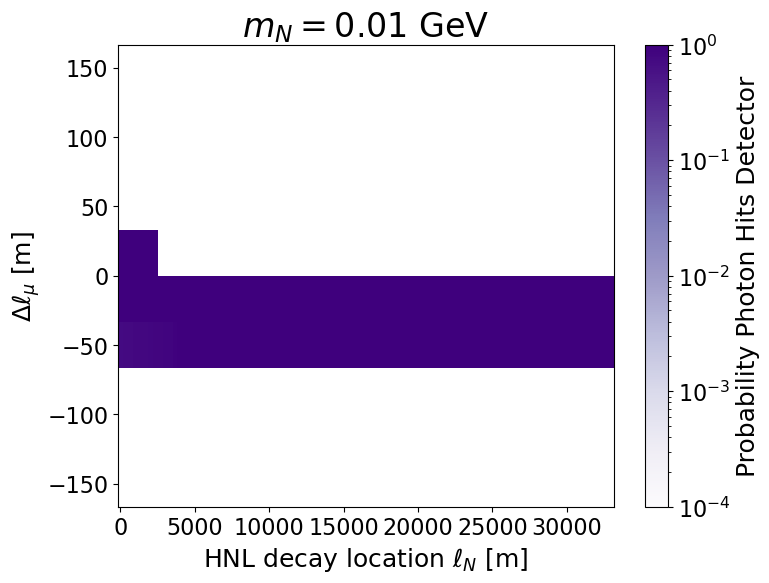

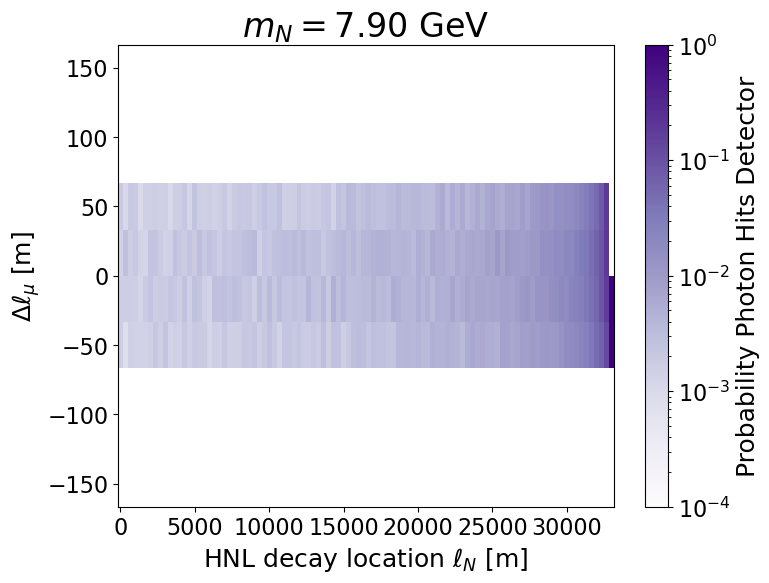

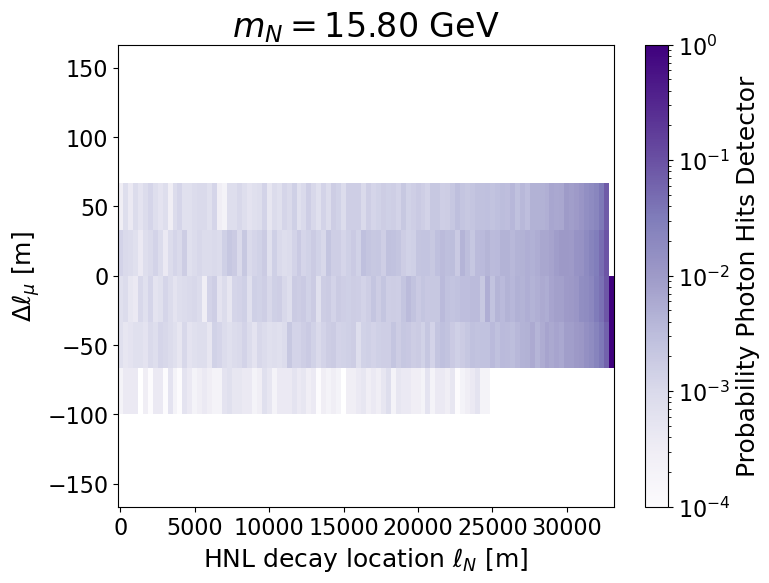

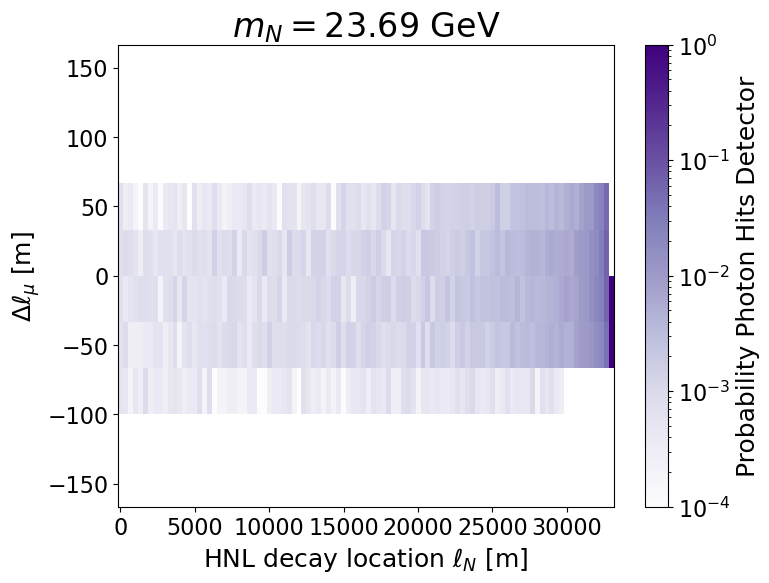

In [26]:
l_N_mesh,delta_l_mu_mesh = np.meshgrid(l_N_range,delta_l_mu_range)
for m_N in m_N_range_sparse[0:-10:3]:
    plt.pcolormesh(l_N_mesh,delta_l_mu_mesh,F_c_arr[m_N].T,norm=LogNorm(vmin=1e-4,vmax=1),shading='auto')
    plt.ylabel(r"$\Delta \ell_\mu$ [m]")
    plt.xlabel(r"HNL decay location $\ell_N$ [m]")
    c = plt.colorbar()
    c.set_label("Probability Photon Hits Detector")
    plt.title("$m_N = %1.2f$ GeV" % m_N)
    plt.savefig("Figures/balloon/decay_location_vs_photons_mN_%1.2f_GeV.png"%m_N, dpi=300)
    plt.show()

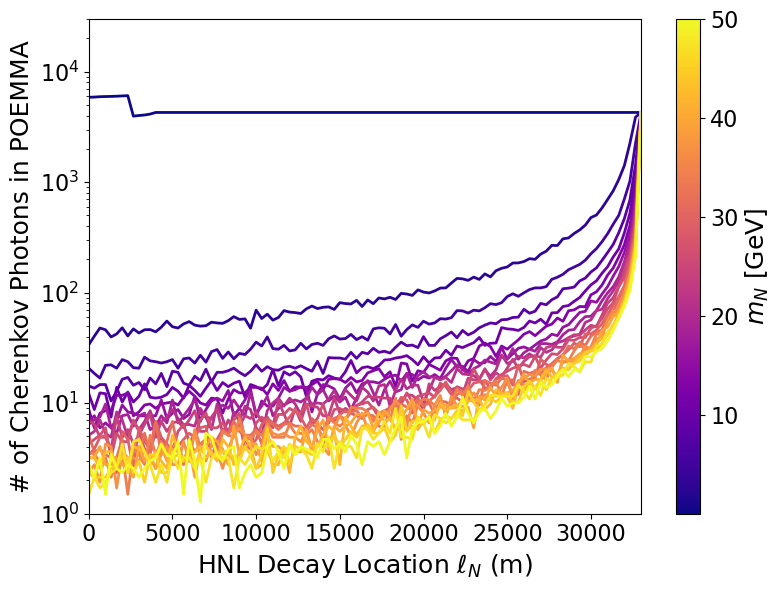

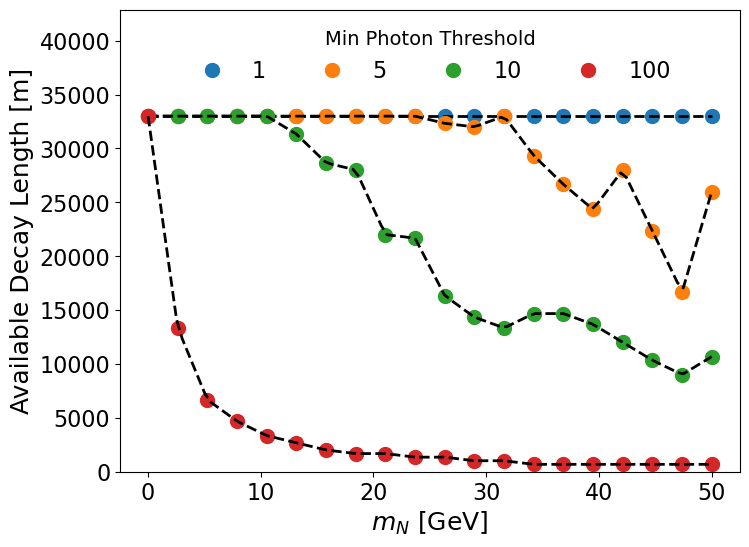

In [27]:
available_decay_length = {}
min_photon_points = [1,5,10,100]

# Use plasma colormap
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

# Normalize the mass range for colormap
m_N_array = np.array(list(m_N_range_sparse))
norm = Normalize(vmin=m_N_array.min(), vmax=m_N_array.max())
cmap = cm.plasma

# Smoothing parameter (sigma for Gaussian filter)
# Larger values = more smoothing. Try values between 1-5
smooth_sigma = 3

fig, ax = plt.subplots()
for m_N in m_N_range_sparse:
    color = cmap(norm(m_N))

    # Apply Gaussian smoothing
    #N_gamma_smooth = gaussian_filter1d(N_gamma[m_N], sigma=smooth_sigma)

    #ax.plot(l_N_range, N_gamma_smooth, color=color, linewidth=2)
    ax.plot(l_N_range, N_gamma[m_N], color=color, linewidth=2)

    for min_photons in min_photon_points:
        if min_photons not in available_decay_length.keys():
            available_decay_length[min_photons] = []
        # Use unsmoothed data for threshold calculation
        valid_points = l_N_range[N_gamma[m_N] >= min_photons]
        if len(valid_points) > 0:
            available_decay_length[min_photons].append(L_det - np.min(valid_points))
        else:
            available_decay_length[min_photons].append(0)

ax.set_yscale('log')
ax.set_xlabel(r"HNL Decay Location $\ell_N$ (m)")
ax.set_ylabel(r"# of Cherenkov Photons in POEMMA")
ax.set_xlim(l_N_range[0], l_N_range[-1])
ax.set_ylim(1, 3e4)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label=r'$m_N$ [GeV]')
plt.tight_layout()
plt.savefig("Figures/balloon/decay_location_vs_photons.png", dpi=300)
plt.show()

# Plot available decay length
available_decay_length_interp = {}
for min_photons in min_photon_points:
    plt.plot(list(m_N_range_sparse), available_decay_length[min_photons],
             label=min_photons, marker='o',linewidth=0)
    available_decay_length_interp[min_photons] = interp1d(
        np.array(m_N_range_sparse),
        np.array(available_decay_length[min_photons]),
        kind='linear',
        fill_value="extrapolate"
    )
    plt.plot(np.linspace(m_N_range_sparse[0], m_N_range_sparse[-1], 100),
             available_decay_length_interp[min_photons](np.linspace(m_N_range_sparse[0], m_N_range_sparse[-1], 100)),
             color="black",linestyle='--')
plt.xlabel(r"$m_N$ [GeV]")
plt.ylabel("Available Decay Length [m]")
plt.legend(title="Min Photon Threshold",ncol=4,loc="upper center")
plt.ylim(0,1.3*L_det)
# plt.semilogy()
plt.savefig("Figures/balloon/available_decay_length.png",dpi=300)
plt.show()

# Now for the event rate calculation

In [28]:
def event_rate(m_N,E_mu,U2,N_muon,L_det,L_target,buffer=10,min_photons=None):

    l_N_val = HNL_decay_length(m_N, U2, E_mu)
    sigma_val = sigma(E_mu, m_N, U2)

    if min_photons is not None:
        buffer_proxy = L_det - available_decay_length_interp[min_photons](m_N)
        buffer = np.where(buffer_proxy > buffer, buffer_proxy, buffer)



    prefactor = N_muon * n_earth_m3 * sigma_val * l_N_val  # dimensionless
    long_lived_mask = l_N_val/(L_det + L_target + buffer) > 10
    prob_term = np.exp(-buffer / l_N_val) - np.exp(-L_det / l_N_val) - np.exp(-(L_target + buffer) / l_N_val) + np.exp(-(L_det + L_target) / l_N_val)
    prob_term_approx = ((L_det-buffer) * L_target) / (l_N_val**2)
    prob_term = np.where(long_lived_mask, prob_term_approx, prob_term)

    return prefactor * prob_term

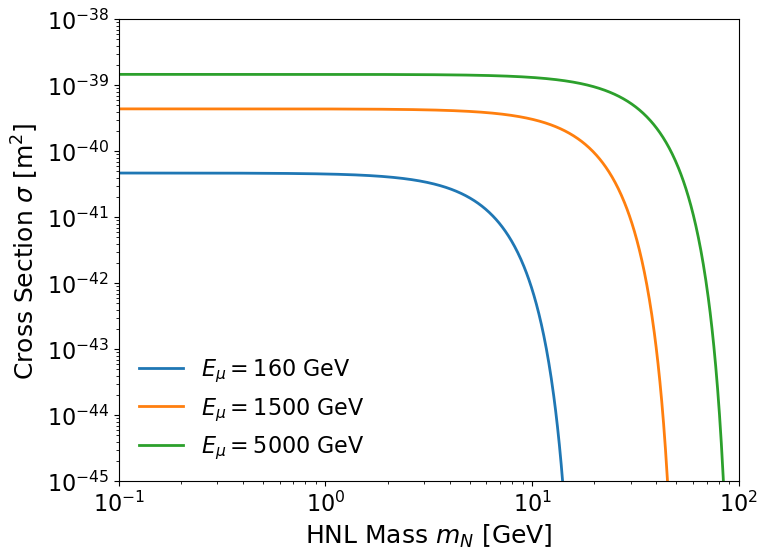

In [32]:
E_mu_range = [160,1500,5000]
m_N_range = np.logspace(-1,2,1000) # GeV
for E_mu in E_mu_range:
    plt.plot(m_N_range, sigma(E_mu, m_N_range, 1), label=f"$E_\\mu = {E_mu}$ GeV")
plt.loglog()
plt.legend()
plt.xlabel(r"HNL Mass $m_N$ [GeV]")
plt.ylabel(r"Cross Section $\sigma$ [m$^2$]")
plt.ylim(1e-45,1e-38)
plt.xlim(m_N_range[0],m_N_range[-1])
plt.show()

In [33]:
U2_range = np.logspace(-16,-2,100)
L_target = 1e3 / 3 # m

m_N_mesh,U2_mesh = np.meshgrid(m_N_range,U2_range)
rate_mesh_100 = event_rate(m_N_mesh, E_mu, U2_mesh, N_muon=1e21, L_det=L_det, L_target=L_target,min_photons=100)
rate_mesh_10 = event_rate(m_N_mesh, E_mu, U2_mesh, N_muon=1e21, L_det=L_det, L_target=L_target,min_photons=10)
rate_mesh_1 = event_rate(m_N_mesh, E_mu, U2_mesh, N_muon=1e21, L_det=L_det, L_target=L_target,min_photons=1)

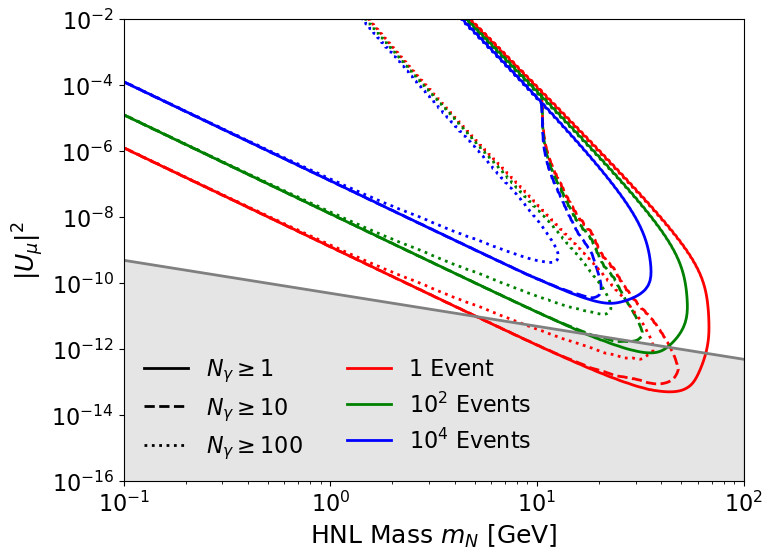

In [34]:
#plt.pcolormesh(m_N_mesh,U2_mesh,rate_mesh_none,norm=LogNorm(vmin=1e-2,vmax=1e10),shading='auto')
#c = plt.colorbar()
#c.set_label(r"Event Rate")

contours_10 = plt.contour(m_N_mesh, U2_mesh, rate_mesh_10, levels=[1,1e2,1e4], colors=["red","green","blue"], linestyles='dashed')
contours_100 = plt.contour(m_N_mesh, U2_mesh, rate_mesh_100, levels=[1,1e2,1e4], colors=["red","green","blue"], linestyles='dotted')
contours_1 = plt.contour(m_N_mesh, U2_mesh, rate_mesh_1, levels=[1,1e2,1e4], colors=["red","green","blue"], linestyles='solid')

# save contours
for n_min,CS in zip([1,10,100],[contours_1,contours_10,contours_100]):
    for level,path in enumerate(CS.get_paths()):
        contour_file = open("data/balloon_contours/HNL_events_%d_nmin_%d.txt"%(level,n_min), "w")
        v = path.vertices
        for vertex in v:
            contour_file.write(f"{vertex[0]} {vertex[1]}\n")
        contour_file.write("\n")  # separate different segments
    contour_file.close()


plt.plot([],[], color="black", linestyle='solid', label=r'$N_{\gamma} \geq 1$')
plt.plot([],[], color="black", linestyle='dashed', label=r'$N_{\gamma} \geq 10$')
plt.plot([],[], color="black", linestyle='dotted', label=r'$N_{\gamma} \geq 100$')
plt.plot([],[], color="red", label = r"1 Event")
plt.plot([],[], color="green", label = r"$10^2$ Events")
plt.plot([],[], color="blue", label = r"$10^4$ Events")


# seesaw bound
U2_seesaw_upper = 5e-11 / m_N_range
plt.fill_between(m_N_range,0,U2_seesaw_upper,color="gray",alpha=0.2)
plt.plot(m_N_range,U2_seesaw_upper,color="gray")
#plt.text(0,0,"Seesaw")

plt.legend(ncol=2,loc="lower left")
plt.loglog()
plt.xlabel(r"HNL Mass $m_N$ [GeV]")
plt.ylabel(r"$|U_\mu|^2$")
plt.savefig("Figures/balloon/balloon_sensitivity_example.png",dpi=300)
plt.show()

## Accounting for HNL spread from source

In [35]:
# Import the generalized Cherenkov module
from src.cherenkov import (
    cherenkov_photons_detected_vectorized,
    get_cherenkov_angle,
    get_cherenkov_yield_per_meter,
    CherenkovLookupTable
)

# Verify constants match
print("Cherenkov module constants:")
print(f"  Cherenkov angle: {np.degrees(get_cherenkov_angle()):.4f} deg (notebook: {np.degrees(theta_C):.4f} deg)")
print(f"  Photon yield: {get_cherenkov_yield_per_meter():.2f} photons/m (notebook: {Ch_dN_dx:.2f} photons/m)")

Cherenkov module constants:
  Cherenkov angle: 1.4033 deg (notebook: 1.4033 deg)
  Photon yield: 64.16 photons/m (notebook: 64.18 photons/m)


Test: particle at z = -10000 m, track length = 40000 m
Detector radius: 2 m



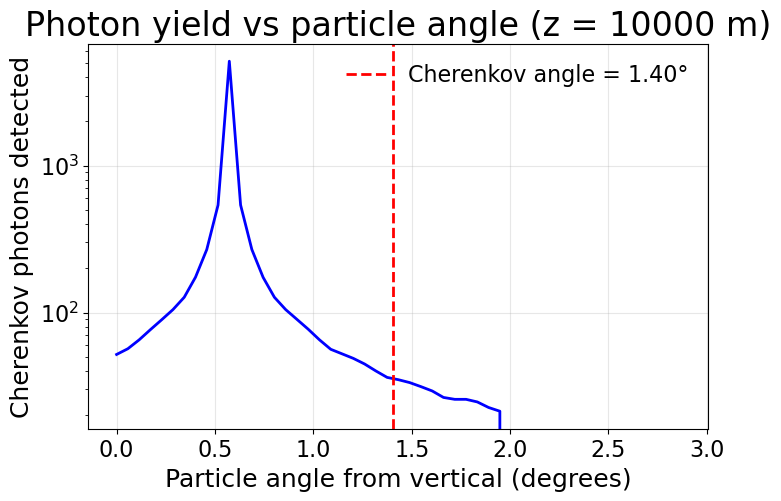

In [36]:
# Demonstrate the generalized Cherenkov function
# Convention: detector is a disk at z=0, particles come from z < 0

# Example: particle at 1 km below detector, traveling at various angles
z_test = 10000  # m below detector
track_length = 40000  # m

print(f"Test: particle at z = -{z_test} m, track length = {track_length} m")
print(f"Detector radius: {R_det} m")
print()

# Scan particle angles to show how photon count varies
theta_range = np.linspace(0, 0.05, 51)  # 0 to ~3 degrees

N_photons_list = []
for theta in theta_range:
    r_0 = np.array([-100, 0, -z_test])
    p_hat = np.array([np.sin(theta), 0, np.cos(theta)])
    N_ph = cherenkov_photons_detected_vectorized(r_0, p_hat, track_length, R_det, N_track=1000, N_psi=10000)
    N_photons_list.append(N_ph)

plt.figure(figsize=(8, 5))
plt.plot(np.degrees(theta_range), N_photons_list, 'b-', linewidth=2)
plt.axvline(np.degrees(theta_C), color='r', linestyle='--', label=f'Cherenkov angle = {np.degrees(theta_C):.2f}°')
plt.xlabel('Particle angle from vertical (degrees)')
plt.ylabel('Cherenkov photons detected')
plt.title(f'Photon yield vs particle angle (z = {z_test} m)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.semilogy()
plt.show()

Computing photon map...
  10/30 complete
  20/30 complete
  30/30 complete
Done!


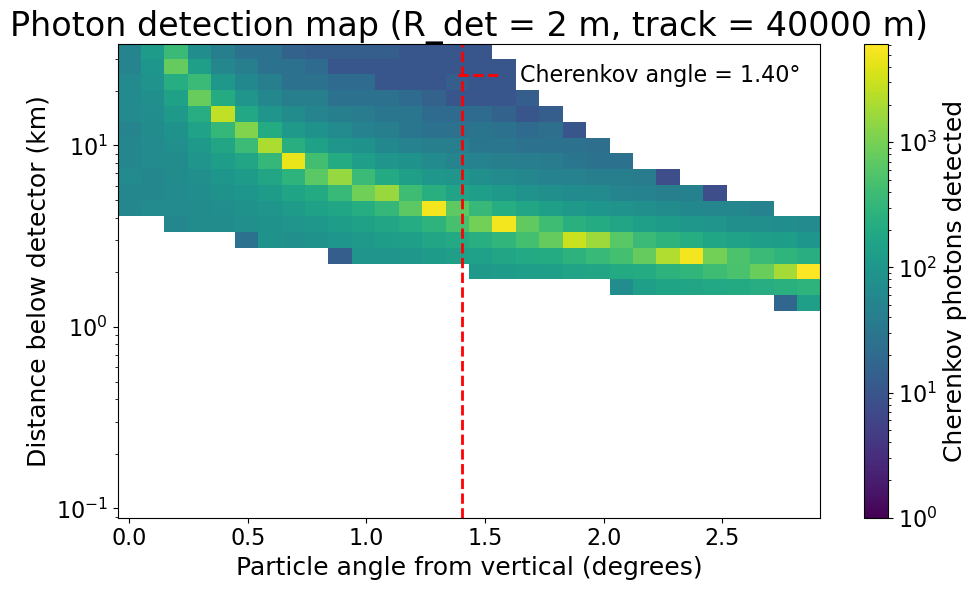

In [37]:
# Create a 2D map: photon count as function of (z, theta)
# This shows where in parameter space we get good photon collection

z_range_map = np.logspace(2, np.log10(L_det), 30)  # 100 m to 33 km
theta_range_map = np.linspace(0, 0.05, 30)  # 0 to ~3 degrees
track_length = 40000  # m

N_photons_map = np.zeros((len(z_range_map), len(theta_range_map)))

print("Computing photon map...")
for iz, z in enumerate(z_range_map):
    for ith, theta in enumerate(theta_range_map):
        r_0 = np.array([-100, 0, -z])
        p_hat = np.array([np.sin(theta), 0, np.cos(theta)])
        N_photons_map[iz, ith] = cherenkov_photons_detected_vectorized(
            r_0, p_hat, track_length, R_det, N_psi=1000, N_track=1000
        )
    if (iz + 1) % 10 == 0:
        print(f"  {iz+1}/{len(z_range_map)} complete")

print("Done!")

# Plot
theta_mesh, z_mesh = np.meshgrid(np.degrees(theta_range_map), z_range_map/1000)

plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(theta_mesh, z_mesh, N_photons_map,
                      norm=LogNorm(vmin=1, vmax=N_photons_map.max()),
                      shading='auto', cmap='viridis')
plt.axvline(np.degrees(theta_C), color='r', linestyle='--', linewidth=2,
            label=f'Cherenkov angle = {np.degrees(theta_C):.2f}°')
plt.colorbar(pcm, label='Cherenkov photons detected')
plt.xlabel('Particle angle from vertical (degrees)')
plt.ylabel('Distance below detector (km)')
plt.yscale('log')
plt.title(f'Photon detection map (R_det = {R_det} m, track = {track_length} m)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("Figures/balloon/cherenkov_photon_map.png", dpi=300)
plt.show()

In [ ]:
# Build a lookup table for fast interpolation
# This takes a few minutes but enables fast evaluation for Monte Carlo integration

import os

lut_path = "data/cherenkov_lookup_table.npz"

# Check if lookup table already exists
if os.path.exists(lut_path):
    print(f"Loading existing lookup table from {lut_path}")
    cherenkov_lut = CherenkovLookupTable.load(lut_path)
else:
    print("Building lookup table (this may take a few minutes)...")
    cherenkov_lut = CherenkovLookupTable(
        R_det=R_det,
        z_range=(0, 50),      # 0 m to 50 km below detector
        r_range=(0, 1000),           # 0 to 500 m radial offset
        theta_range=(0, 0.3),       # 0 to ~6 degrees particle angle
        N_z=100,
        N_r=100,
        N_theta=100,
        N_phi=100
    )
    cherenkov_lut.build(verbose=True)
    cherenkov_lut.save(lut_path)
    print(f"Saved lookup table to {lut_path}")

# Test the lookup table
print("\nLookup table test:")
print(f"  N_photons(z=1km, r=0, theta=0.01, phi=0) = {cherenkov_lut(1000, 0, 0.01, 0):.1f}")
print(f"  N_photons(z=10km, r=0, theta=0.02, phi=0) = {cherenkov_lut(10000, 0, 0.02, 0):.1f}")

Loading existing lookup table from data/cherenkov_lookup_table.npz

Lookup table test:
  N_photons(z=1km, r=0, theta=0.01, phi=0) = 957.5
  N_photons(z=10km, r=0, theta=0.02, phi=0) = 0.0


In [41]:
def compute_photons_with_hnl_spread_realistic(m_N, E_N, z_decay, N_samples=1000):
    """
    Compute expected photons accounting for HNL angular spread AND realistic muon tracks.

    Parameters
    ----------
    m_N : float
        HNL mass [GeV]
    E_N : float
        HNL energy [GeV]
    z_decay : float
        Distance below detector where HNL decays [m]
    N_samples : int
        Number of Monte Carlo samples

    Returns
    -------
    mean_photons : float
        Mean number of photons detected
    std_photons : float
        Standard deviation
    """
    # Detector altitude
    balloon_altitude = L_det  # 33 km
    decay_altitude = balloon_altitude - z_decay

    # HNL opening angle
    theta_hnl = m_N / E_N
    gamma_N = E_N / m_N

    # Sample HNL directions (small angles from vertical)
    theta_N_samples = np.abs(np.random.normal(0, theta_hnl, N_samples))
    phi_N_samples = np.random.uniform(0, 2*np.pi, N_samples)

    # Sample decay product angles relative to HNL direction
    # In lab frame, boosted forward with typical angle ~ 1/gamma
    theta_decay = np.random.exponential(1/gamma_N, N_samples)
    phi_decay = np.random.uniform(0, 2*np.pi, N_samples)

    # Combine angles
    theta_total = np.sqrt(theta_N_samples**2 + theta_decay**2 +
                          2*theta_N_samples*theta_decay*np.cos(phi_decay))
    phi_total = phi_N_samples

    # Sample muon energies
    E_mu_mean, E_mu_std = muon_energy_from_hnl_decay(m_N, E_N)
    E_mu_samples = np.random.normal(E_mu_mean, E_mu_std, N_samples)
    E_mu_samples = np.maximum(E_mu_samples, m_mu)  # can't be below rest mass

    # Compute photons for each sample
    photon_counts = []

    for i in range(N_samples):
        theta = theta_total[i]
        phi = phi_total[i]
        E_mu = E_mu_samples[i]

        # Calculate realistic track length
        cos_theta = np.cos(theta)
        track_length = muon_range_in_air(E_mu, decay_altitude, direction_cosine=max(cos_theta, 0.1))

        # Direct calculation with realistic track length
        r_0 = np.array([0, 0, -z_decay])
        p_hat = np.array([np.sin(theta)*np.cos(phi),
                         np.sin(theta)*np.sin(phi),
                         np.cos(theta)])

        # Adaptive N_track based on track length
        N_track = max(50, min(500, int(track_length / 100)))

        N_ph = cherenkov_photons_detected_vectorized(
            r_0, p_hat, track_length, R_det,
            N_psi=50, N_track=N_track
        )

        photon_counts.append(N_ph)

    return np.mean(photon_counts), np.std(photon_counts)


# Test the new function
print("Testing realistic muon track calculation:")
print("=" * 70)

# Show muon ranges for different energies
print("\nMuon ranges in air (starting at 20 km altitude, going up):")
for E in [10, 50, 100, 500]:
    r = muon_range_in_air(E, 0)
    print(f"  E_mu = {E:4d} GeV  -->  range = {r/1000:.1f} km")

print("\nMuon energy from HNL decay:")
for m_N_test in [5, 10, 20, 30]:
    E_mean, E_std = muon_energy_from_hnl_decay(m_N_test, E_mu/2)
    print(f"  m_N = {m_N_test:2d} GeV, E_N = {E_mu/2:.0f} GeV  -->  E_mu = {E_mean:.0f} +/- {E_std:.0f} GeV")

Testing realistic muon track calculation:

Muon ranges in air (starting at 20 km altitude, going up):
  E_mu =   10 GeV  -->  range = 33.0 km
  E_mu =   50 GeV  -->  range = 33.0 km
  E_mu =  100 GeV  -->  range = 33.0 km
  E_mu =  500 GeV  -->  range = 33.0 km

Muon energy from HNL decay:
  m_N =  5 GeV, E_N = 2500 GeV  -->  E_mu = 1250 +/- 624 GeV
  m_N = 10 GeV, E_N = 2500 GeV  -->  E_mu = 1250 +/- 625 GeV
  m_N = 20 GeV, E_N = 2500 GeV  -->  E_mu = 1250 +/- 625 GeV
  m_N = 30 GeV, E_N = 2500 GeV  -->  E_mu = 1250 +/- 625 GeV


In [43]:
z_decay_test = 10000  # 10 km below detector
E_N_test = E_mu / 2

print(f"\nAt z_decay = {z_decay_test/1000:.0f} km, E_N = {E_N_test:.0f} GeV:")
print(f"{'m_N (GeV)':<12} {'Realistic track':<20}")
print("-" * 55)

for m_N_test in [1, 5, 10, 20, 30]:

    # New calculation (realistic track lengths)
    mean_new, std_new = compute_photons_with_hnl_spread_realistic(m_N_test, E_N_test, z_decay_test, N_samples=200)

    print(f"{m_N_test:<12} {mean_new:>6.0f} +/- {std_new:<8.0f}")


At z_decay = 10 km, E_N = 2500 GeV:
m_N (GeV)    Realistic track     
-------------------------------------------------------
1              1177 +/- 591     
5               412 +/- 504     
10              188 +/- 300     
20              113 +/- 224     
30               57 +/- 103     


Computing for m_N = 1 GeV...
Computing for m_N = 5 GeV...
Computing for m_N = 10 GeV...
Computing for m_N = 20 GeV...
Computing for m_N = 30 GeV...


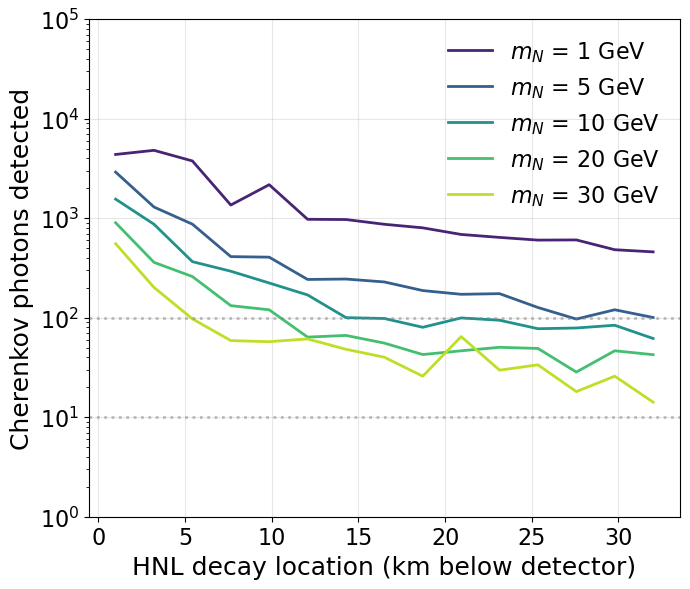


Key insight: Low-mass HNLs benefit enormously from realistic track lengths!
This is because low-mass HNLs have smaller opening angles, keeping the
muon track closer to the detector axis for longer distances.


In [ ]:
# Full comparison plot: photon yield vs decay location

z_decay_range = np.linspace(1000, L_det-1000, 15)  # 1 km to 32 km below detector
m_N_values = [1, 5, 10, 20, 30]  # GeV
E_N_test = E_mu / 2

fig, ax = plt.subplots(1,1, figsize=(7, 6))

# Color map for masses
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(m_N_values)))

# Left plot: Photon yield comparison

for m_N_test, color in zip(m_N_values, colors):
    mean_photons_new = []

    print(f"Computing for m_N = {m_N_test} GeV...")
    for z in z_decay_range:

        # New calculation (realistic track)
        mean_new, _ = compute_photons_with_hnl_spread_realistic(m_N_test, E_N_test, z, N_samples=100)
        mean_photons_new.append(mean_new)

    ax.plot(z_decay_range/1000, mean_photons_new, '-', color=color, linewidth=2,
            label=f'$m_N$ = {m_N_test} GeV')

ax.set_xlabel('HNL decay location (km below detector)')
ax.set_ylabel('Cherenkov photons detected')
ax.set_yscale('log')
ax.set_ylim(1, 1e5)
ax.axhline(10, color='gray', linestyle=':', alpha=0.5)
ax.axhline(100, color='gray', linestyle=':', alpha=0.5)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Figures/balloon/photon_yield_realistic_comparison.png", dpi=300)
plt.show()

print("\nKey insight: Low-mass HNLs benefit enormously from realistic track lengths!")
print("This is because low-mass HNLs have smaller opening angles, keeping the")
print("muon track closer to the detector axis for longer distances.")

## Full HNL Flux Geometry

Now we account for the angular spread of the HNL flux from production in the Earth.

**Geometry:**
- Muon beam travels UPWARD through Earth, emerging toward the satellite
- HNLs are produced at tunable depth below surface via $\mu + N \to N_{\rm HNL} + X$
- Production angle: $\theta_{\rm prod} \sim m_N / E_\mu$ relative to beam direction
- HNLs travel upward and decay in atmosphere
- Satellite at tunable height $z_{\rm sat}$ above the surface

**Coordinate system:**
- Origin at Earth surface, directly below the satellite
- $z$-axis points up (away from Earth)
- $x$-axis in horizontal plane, along beam offset direction
- Beam emerges from underground, traveling upward with tunable offset angle from vertical

In [54]:



# Test the upward beam geometry
print("Testing HNL Flux Geometry - Upward Beam Configuration")
print("=" * 65)

# Create geometry: beam coming out of Earth, aimed nearly at satellite
flux_geom = HNLFluxGeometry(
    E_mu=1.5e3,            # 1500 GeV muon beam
    beam_offset_angle=0.01,   # ~0.6 degrees off vertical (nearly at satellite)
    target_depth=100,         # 100 m below surface
    satellite_height=100e3,#L_det,   # 33 km altitude
    L_target=200              # 200 m target length
)

print(f"Muon beam energy: {flux_geom.E_mu} GeV")
print(f"Beam offset angle: {np.degrees(flux_geom.beam_offset_angle):.2f} deg from vertical")
print(f"Beam direction: ({flux_geom.beam_dir[0]:.4f}, {flux_geom.beam_dir[1]:.4f}, {flux_geom.beam_dir[2]:.4f})")
print(f"Target depth: {flux_geom.target_depth} m")
print(f"Satellite height: {flux_geom.satellite_height/1000:.1f} km")
print(f"Target length: {flux_geom.L_target} m")

# Test: what fraction of HNLs go upward?
print(f"\n--- HNL Direction Test (m_N = 10 GeV) ---")
hnl_dirs = flux_geom.sample_hnl_directions(m_N=10, N_samples=10000)
upward_going = hnl_dirs[:, 2] > 0
print(f"Fraction going upward (z > 0): {np.mean(upward_going):.1%}")
print(f"Fraction with z > 0.9: {np.mean(hnl_dirs[:, 2] > 0.9):.1%}")

# Test: how many reach atmosphere?
print(f"\n--- Decay Location Test ---")
m_N_test = 10
U2_test = 1e-10  # use larger mixing for more decays in atmosphere
E_N_test = E_mu / 2
decay_length = HNL_decay_length(m_N_test, U2_test, E_N_test)
print(f"Decay length (U2={U2_test:.0e}): {decay_length:.0f} m")

prod_pts = flux_geom.sample_production_points(10000)
hnl_dirs = flux_geom.sample_hnl_directions(m_N_test, 10000)
decay_pts, _ = flux_geom.sample_decay_points(prod_pts, hnl_dirs, decay_length)

print(prod_pts)
print(decay_pts)

in_atmosphere = (decay_pts[:, 2] > 0) & (decay_pts[:, 2] < flux_geom.satellite_height)
print(f"Decays in atmosphere: {np.sum(in_atmosphere)} / 10000 ({np.mean(in_atmosphere):.1%})")

# Show distribution of decay altitudes for atmospheric decays
if np.sum(in_atmosphere) > 0:
    atm_z = decay_pts[in_atmosphere, 2]
    print(f"Decay altitude range: {atm_z.min()/1000:.1f} - {atm_z.max()/1000:.1f} km")

Testing HNL Flux Geometry - Upward Beam Configuration
Muon beam energy: 1500.0 GeV
Beam offset angle: 0.57 deg from vertical
Beam direction: (0.0100, 0.0000, 1.0000)
Target depth: 100 m
Satellite height: 100.0 km
Target length: 200 m

--- HNL Direction Test (m_N = 10 GeV) ---
Fraction going upward (z > 0): 100.0%
Fraction with z > 0.9: 100.0%

--- Decay Location Test ---
Decay length (U2=1e-10): 64807 m
[[  -1.98008163    0.         -198.00156229]
 [  -0.97527553    0.          -97.52430221]
 [  -1.29205264    0.         -129.20095676]
 ...
 [  -0.92868095    0.          -92.86499912]
 [  -1.5014486     0.         -150.139855  ]
 [  -0.95075356    0.          -95.07218704]]
[[ 1.93919774e+03  1.23629533e+02  2.04527614e+05]
 [ 2.47404733e+02 -1.33962664e+02  1.39451547e+04]
 [ 2.51429578e+03  1.36839436e+03  2.29974622e+05]
 ...
 [ 1.47159466e+02  3.11084148e+01  1.17298066e+04]
 [ 4.18033764e+02 -9.10742638e+01  3.78677148e+04]
 [ 9.07080229e+02  5.00085125e+01  1.76508619e+05]]
Decay

Scanning target depth for optimal configuration...
Scanning m_N = 5 GeV...
Scanning m_N = 10 GeV...
Scanning m_N = 20 GeV...


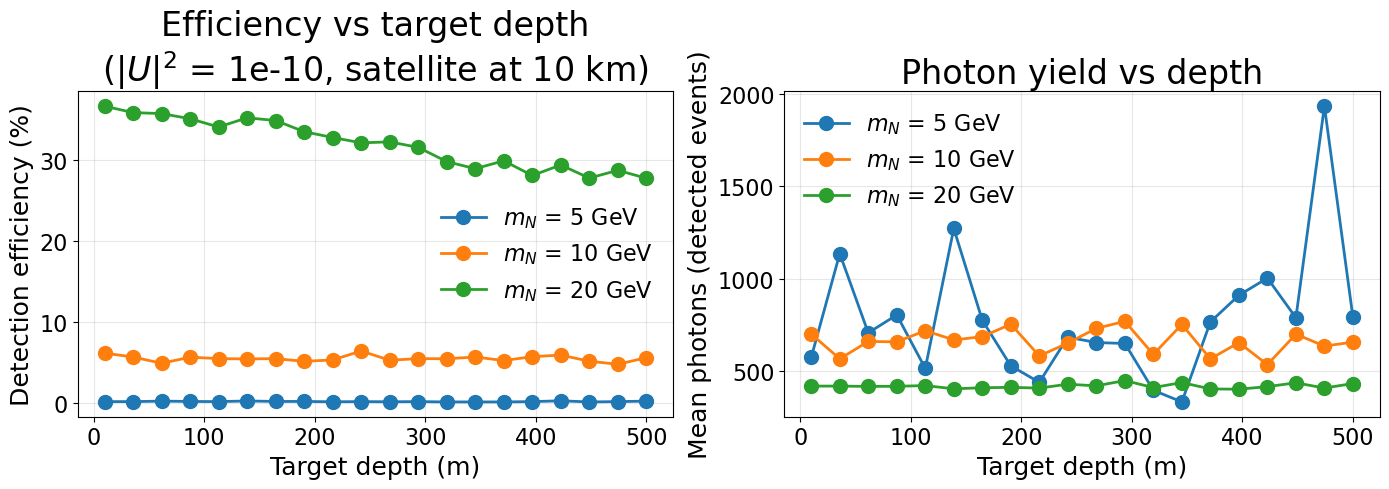


Key trade-off:
  - Shallower target: HNLs reach atmosphere more easily
  - Deeper target: More target material, but HNLs must travel further


In [20]:
# Scan target depth to find optimal beam dump distance from surface

def scan_target_depth(m_N, U2, sat_height, depth_range, beam_offset_angle=0.0,
                      N_samples=1000, min_photons=10):
    """
    Scan target depth and compute detection efficiency.

    Parameters
    ----------
    m_N : float
        HNL mass [GeV]
    U2 : float
        Mixing angle squared
    sat_height : float
        Satellite height above surface [m]
    depth_range : array
        Target depths to scan [m]
    beam_offset_angle : float
        Beam angle from vertical [rad]

    Returns
    -------
    efficiencies : array
        Detection efficiency at each depth
    mean_photons : array
        Mean photon count at each depth
    """
    E_N = E_mu / 2
    efficiencies = []
    mean_photons = []

    for depth in depth_range:
        flux_geom = HNLFluxGeometry(
            E_mu=E_mu,
            beam_offset_angle=beam_offset_angle,
            target_depth=depth,
            satellite_height=sat_height,
        )

        sat_pos = flux_geom.get_satellite_position()
        eff, mph = compute_signal_at_satellite(
            m_N, E_N, U2, sat_pos, flux_geom,
            N_samples=N_samples, min_photons=min_photons
        )

        efficiencies.append(eff)
        mean_photons.append(mph)

    return np.array(efficiencies), np.array(mean_photons)


print("Scanning target depth for optimal configuration...")
print("=" * 65)

# Satellite height
sat_height = 10e3#L_det  # 33 km

# Scan depths from 10m to 500m
depth_range = np.linspace(10, 500, 20)

# Test for different HNL masses
m_N_values = [5, 10, 20]
U2_test = 1e-10  # relatively large mixing for testing

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for m_N in m_N_values:
    print(f"Scanning m_N = {m_N} GeV...")
    eff, mph = scan_target_depth(m_N, U2_test, sat_height, depth_range,
                                  beam_offset_angle=0.0, N_samples=5000)

    axes[0].plot(depth_range, eff * 100, 'o-', label=f'$m_N$ = {m_N} GeV')
    axes[1].plot(depth_range, mph, 'o-', label=f'$m_N$ = {m_N} GeV')

axes[0].set_xlabel('Target depth (m)')
axes[0].set_ylabel('Detection efficiency (%)')
axes[0].set_title(f'Efficiency vs target depth\n($|U|^2$ = {U2_test:.0e}, satellite at {sat_height/1000:.0f} km)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Target depth (m)')
axes[1].set_ylabel('Mean photons (detected events)')
axes[1].set_title('Photon yield vs depth')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Figures/balloon/target_depth_scan.png", dpi=300)
plt.show()

print("\nKey trade-off:")
print("  - Shallower target: HNLs reach atmosphere more easily")
print("  - Deeper target: More target material, but HNLs must travel further")

Scanning satellite positions...
  Row 1/12 complete
  Row 2/12 complete
  Row 3/12 complete
  Row 4/12 complete
  Row 5/12 complete
  Row 6/12 complete
  Row 7/12 complete
  Row 8/12 complete
  Row 9/12 complete
  Row 10/12 complete
  Row 11/12 complete
  Row 12/12 complete
Done!


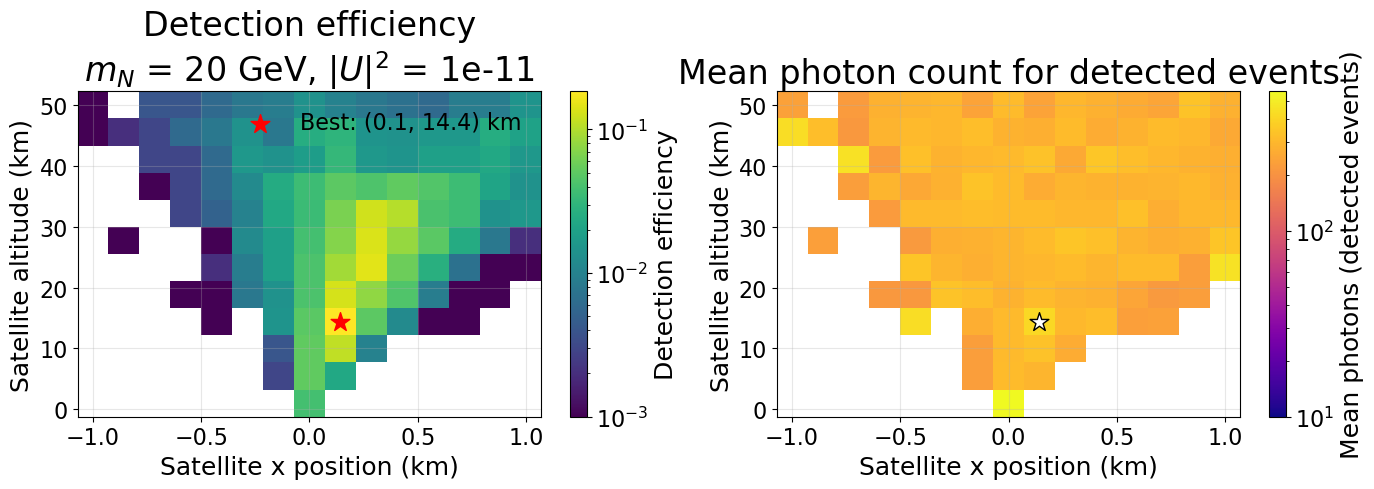


Optimal satellite position: x = 0.1 km, z = 14.4 km
Maximum detection efficiency: 0.184


In [21]:
# Scan satellite positions to find optimal placement

def scan_satellite_positions(flux_geometry, m_N, U2,
                             x_range, z_range,
                             N_samples=10000, min_photons=3):
    """
    Scan satellite positions and compute detection efficiency at each.

    Returns
    -------
    efficiency_map : ndarray
        2D array of detection efficiencies
    photon_map : ndarray
        2D array of mean photon counts
    """
    E_N = flux_geometry.E_mu / 2

    efficiency_map = np.zeros((len(z_range), len(x_range)))
    photon_map = np.zeros((len(z_range), len(x_range)))

    total = len(z_range) * len(x_range)
    count = 0

    for iz, z_sat in enumerate(z_range):
        for ix, x_sat in enumerate(x_range):
            sat_pos = np.array([x_sat, 0, z_sat])

            eff, mean_ph = compute_signal_at_satellite(
                m_N, E_N, U2, sat_pos, flux_geometry,
                N_samples=N_samples, min_photons=min_photons
            )

            efficiency_map[iz, ix] = eff
            photon_map[iz, ix] = mean_ph

            count += 1

        print(f"  Row {iz+1}/{len(z_range)} complete")

    return efficiency_map, photon_map


# Scan a grid of satellite positions
print("Scanning satellite positions...")
print("=" * 60)

# For a horizontal beam, HNLs go mostly in the +x direction
# So we scan x from -5 km to +20 km, and z from 10 km to 50 km

x_scan = np.linspace(-1000, 1000, 15)  # -5 to +20 km
z_scan = np.linspace(1000, 50000, 12)   # 10 to 50 km altitude

# Test with one HNL mass and mixing
m_N_test = 20  # GeV
U2_test = 1e-11

eff_map, ph_map = scan_satellite_positions(
    flux_geom, m_N_test, U2_test,
    x_scan, z_scan,
    N_samples=1000, min_photons=1
)

print("Done!")

# Plot results
x_mesh, z_mesh = np.meshgrid(x_scan/1000, z_scan/1000)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Detection efficiency
ax = axes[0]
pcm = ax.pcolormesh(x_mesh, z_mesh, eff_map, shading='auto', cmap='viridis',norm=LogNorm())
plt.colorbar(pcm, ax=ax, label='Detection efficiency')

# Mark the maximum
max_idx = np.unravel_index(np.argmax(eff_map), eff_map.shape)
best_x = x_scan[max_idx[1]] / 1000
best_z = z_scan[max_idx[0]] / 1000
ax.scatter([best_x], [best_z], c='red', s=200, marker='*',
           label=f'Best: ({best_x:.1f}, {best_z:.1f}) km')

ax.set_xlabel('Satellite x position (km)')
ax.set_ylabel('Satellite altitude (km)')
ax.set_title(f'Detection efficiency\n$m_N$ = {m_N_test} GeV, $|U|^2$ = {U2_test:.0e}')
ax.legend()
ax.grid(True, alpha=0.3)

# Mean photons
ax = axes[1]
# Mask zeros for log scale
ph_map_masked = np.ma.masked_where(ph_map == 0, ph_map)
pcm = ax.pcolormesh(x_mesh, z_mesh, ph_map_masked, shading='auto',
                    cmap='plasma', norm=LogNorm(vmin=10, vmax=max(100, ph_map.max())))
plt.colorbar(pcm, ax=ax, label='Mean photons (detected events)')

ax.scatter([best_x], [best_z], c='white', s=200, marker='*', edgecolors='black')

ax.set_xlabel('Satellite x position (km)')
ax.set_ylabel('Satellite altitude (km)')
ax.set_title(f'Mean photon count for detected events')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Figures/balloon/satellite_position_scan.png", dpi=300)
plt.show()

print(f"\nOptimal satellite position: x = {best_x:.1f} km, z = {best_z:.1f} km")
print(f"Maximum detection efficiency: {eff_map.max():.3f}")

Comparing optimal positions for different HNL masses...

m_N = 5 GeV:
  Row 1/24 complete
  Row 2/24 complete
  Row 3/24 complete
  Row 4/24 complete
  Row 5/24 complete
  Row 6/24 complete
  Row 7/24 complete
  Row 8/24 complete
  Row 9/24 complete
  Row 10/24 complete
  Row 11/24 complete
  Row 12/24 complete
  Row 13/24 complete
  Row 14/24 complete
  Row 15/24 complete
  Row 16/24 complete
  Row 17/24 complete
  Row 18/24 complete
  Row 19/24 complete
  Row 20/24 complete
  Row 21/24 complete
  Row 22/24 complete
  Row 23/24 complete
  Row 24/24 complete
  Best position: x = 0.0 km, z = 24.4 km
  Max efficiency: 0.001

m_N = 10 GeV:
  Row 1/24 complete
  Row 2/24 complete
  Row 3/24 complete
  Row 4/24 complete
  Row 5/24 complete
  Row 6/24 complete
  Row 7/24 complete
  Row 8/24 complete
  Row 9/24 complete
  Row 10/24 complete
  Row 11/24 complete
  Row 12/24 complete
  Row 13/24 complete
  Row 14/24 complete
  Row 15/24 complete
  Row 16/24 complete
  Row 17/24 complete
  Row 1

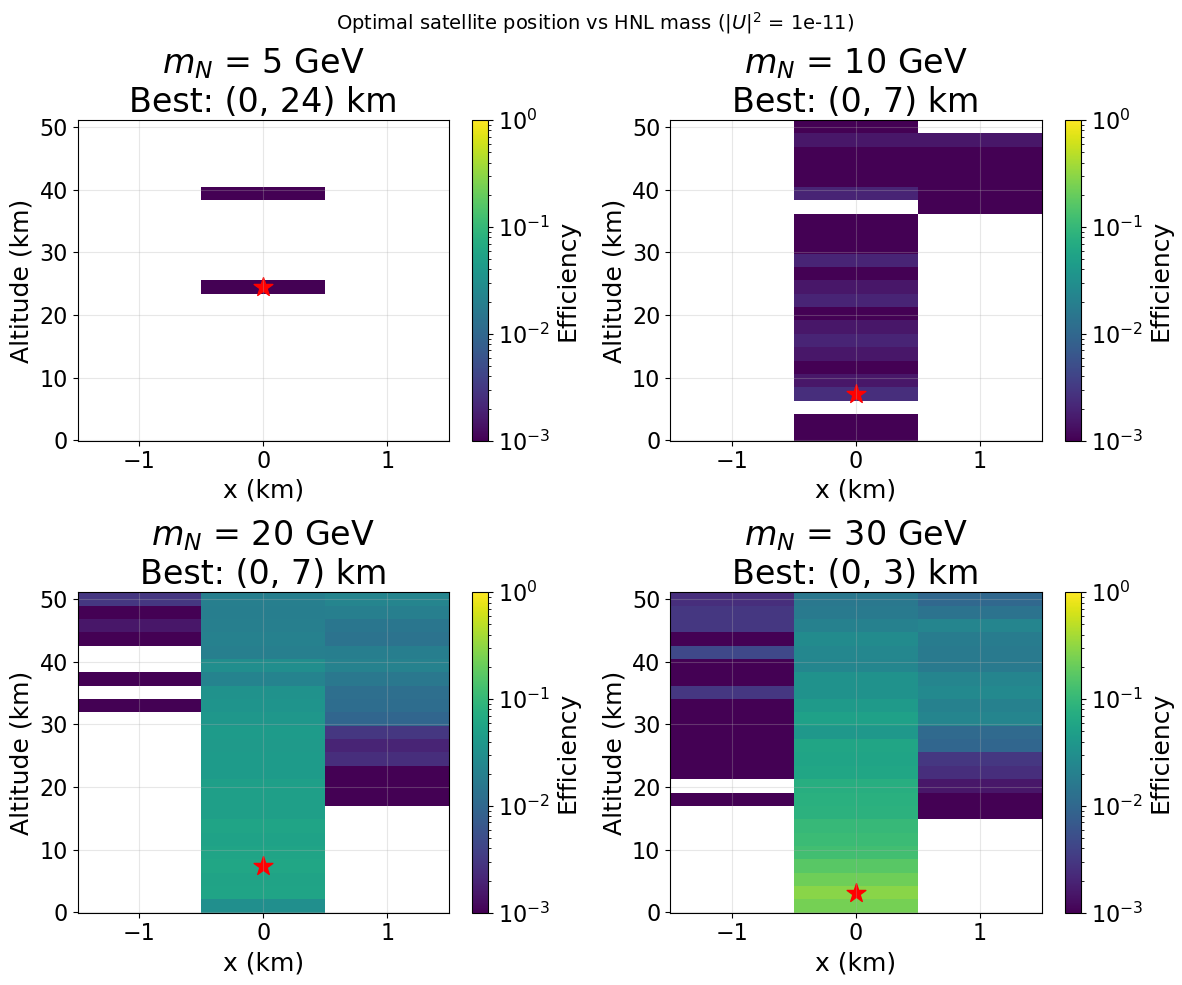


Summary: Optimal satellite positions
m_N (GeV)    x (km)       z (km)       Efficiency  
--------------------------------------------------
5            0.0          24.4         0.001       
10           0.0          7.4          0.003       
20           0.0          7.4          0.059       
30           0.0          3.1          0.290       


In [22]:
# Compare optimal satellite positions for different HNL masses

print("Comparing optimal positions for different HNL masses...")
print("=" * 60)

m_N_scan = [5, 10, 20, 30]
U2_test = 1e-11

# Coarser grid for faster scanning
x_scan_coarse = np.linspace(-1000, 1000, 3)
z_scan_coarse = np.linspace(1000, 50000, 24)

results = {}

for m_N in m_N_scan:
    print(f"\nm_N = {m_N} GeV:")
    eff_map, ph_map = scan_satellite_positions(
        flux_geom, m_N, U2_test,
        x_scan_coarse, z_scan_coarse,
        N_samples=2000, min_photons=3
    )

    max_idx = np.unravel_index(np.argmax(eff_map), eff_map.shape)
    best_x = x_scan_coarse[max_idx[1]] / 1000
    best_z = z_scan_coarse[max_idx[0]] / 1000

    results[m_N] = {
        'eff_map': eff_map,
        'best_x': best_x,
        'best_z': best_z,
        'max_eff': eff_map.max()
    }

    print(f"  Best position: x = {best_x:.1f} km, z = {best_z:.1f} km")
    print(f"  Max efficiency: {eff_map.max():.3f}")

# Summary plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
x_mesh, z_mesh = np.meshgrid(x_scan_coarse/1000, z_scan_coarse/1000)

for ax, m_N in zip(axes.flat, m_N_scan):
    pcm = ax.pcolormesh(x_mesh, z_mesh, results[m_N]['eff_map'],
                        shading='auto', cmap='viridis', norm=LogNorm(vmin=1e-3, vmax=1))
    plt.colorbar(pcm, ax=ax, label='Efficiency')

    # Mark best position
    ax.scatter([results[m_N]['best_x']], [results[m_N]['best_z']],
               c='red', s=200, marker='*')

    ax.set_xlabel('x (km)')
    ax.set_ylabel('Altitude (km)')
    ax.set_title(f'$m_N$ = {m_N} GeV\nBest: ({results[m_N]["best_x"]:.0f}, {results[m_N]["best_z"]:.0f}) km')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Optimal satellite position vs HNL mass ($|U|^2$ = {U2_test:.0e})', fontsize=14)
plt.tight_layout()
plt.savefig("Figures/balloon/satellite_optimization_vs_mass.png", dpi=300)
plt.show()

# Print summary
print("\n" + "=" * 60)
print("Summary: Optimal satellite positions")
print("=" * 60)
print(f"{'m_N (GeV)':<12} {'x (km)':<12} {'z (km)':<12} {'Efficiency':<12}")
print("-" * 50)
for m_N in m_N_scan:
    r = results[m_N]
    print(f"{m_N:<12} {r['best_x']:<12.1f} {r['best_z']:<12.1f} {r['max_eff']:<12.3f}")

In [26]:
flux_geometry = HNLFluxGeometry(
    E_mu=E_mu,
    beam_offset_angle=0.0,
    target_depth=100,
    satellite_height=L_det,
)

m_N_test = 20  # GeV
U2_test = 1e-12

det_eff, mean_photons, n_events = compute_signal_at_satellite(
    m_N_test, E_mu, U2_test,
    flux_geometry,N_samples=5000)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 215.3186729177616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 287.77488337457163, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 334.88331046487076, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 355.6325346122159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 307.99031231799177, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 371.22637411274115, 0.0, 0.0, 329.7114278851777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 327.555855717483, 0.0, 0.0, 338.28991676629596, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 359.9249863388

In [27]:
n_events

3.998217334371168